In [2]:
# Imports we will use
import torch
import gc
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Function
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import random
from pathlib import Path
from sklearn.metrics import r2_score
from astropy.visualization import make_lupton_rgb
from sklearn.manifold import Isomap
from train_utils import *
import time
import os
import json

%matplotlib inline
plt.rcParams.update({'font.size': 12})

# Find if cuda is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [3]:
#fix seed
seed = 102
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.enabled=False
torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED'] = str(seed)

## Load Data

In [4]:
# Specify paths, load in data, and subsample labels
head = Path.cwd().parents[1]
source_img_path = head / 'data/mb_paper_source_final/mb_paper_source_final.npy'
target_img_path = head / 'data/mb_paper_target_final/mb_paper_target_final.npy'
source_meta = head / 'data/mb_paper_source_final/mb_paper_source_final_metadata.csv'
target_meta = head / 'data/mb_paper_target_final/mb_paper_target_final_metadata.csv'
batch_size = 64
source_train_dataloader, source_test_dataloader, source_val_dataloader, source_data = create_dataloader(source_img_path, source_meta, batch_size)
target_train_dataloader, target_test_dataloader, target_val_dataloader, target_data = create_dataloader(target_img_path, target_meta, batch_size)
isomap_source_label_sample = pd.read_csv(source_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]
isomap_target_label_sample = pd.read_csv(target_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]

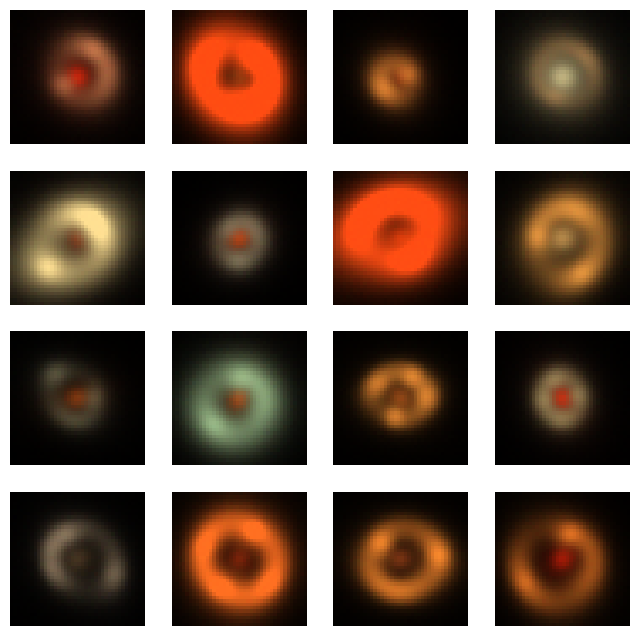

In [5]:
# Visualize source data
visualize_data(source_data)

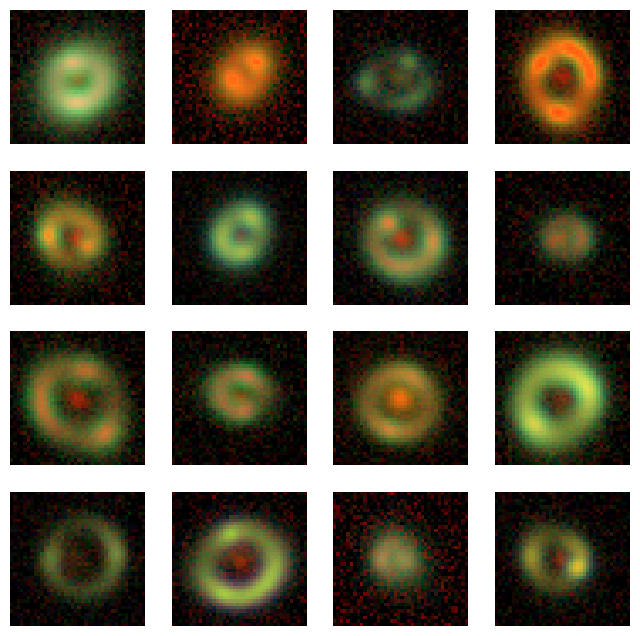

In [6]:
# Visualize target data
visualize_data(target_data)

## Model Setup

In [7]:
# Choose how you prefer to evolve beta and the DA Weight
def da_weight_function(epoch):
    """ Linear evolving DA weighting in loss function. """
    da_weight = init_wt_da - ((init_wt_da - final_wt_da) * (epoch / n_epoch))
    return da_weight

def beta_function(epoch):
    """ Linear evolving beta weighting in loss function until halfway through total epochs. """
    beta_val = beta_init - (beta_init - beta_final) * (epoch / n_epoch)
    return beta_val

# Initialize hyperparameters
learning_rate = 3e-5
n_epoch = 250
init_wt_da = 1.4
final_wt_da = 1.0
beta_init = 1.0
beta_final = 0.0

In [8]:
# Initialize model
model = NeuralNetworkMVE(npix=40).cuda()

# Loss Functions / Optimizers
regressor_loss_fn = nn.MSELoss().cuda()
da_loss_fn = MMD_loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [9]:
# To continue training from a past model, enter path into load_mod_name
# Else, enter None, and you still have to run the function.
# Then, enter save_mod_name to save for the current run  

load_mod_name = None # "models/start_code_test_2"
stats, model, optimizer, best_target_R2, best_mve_loss = initialize_state(load_mod_name, model, optimizer)


#save_mod_name = load_mod_name # may overwrite loaded model
save_mod_name = "models/papermve_v1_aug20_1940_A"

## Train

Beginning Training...
Generating Isomap...


[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


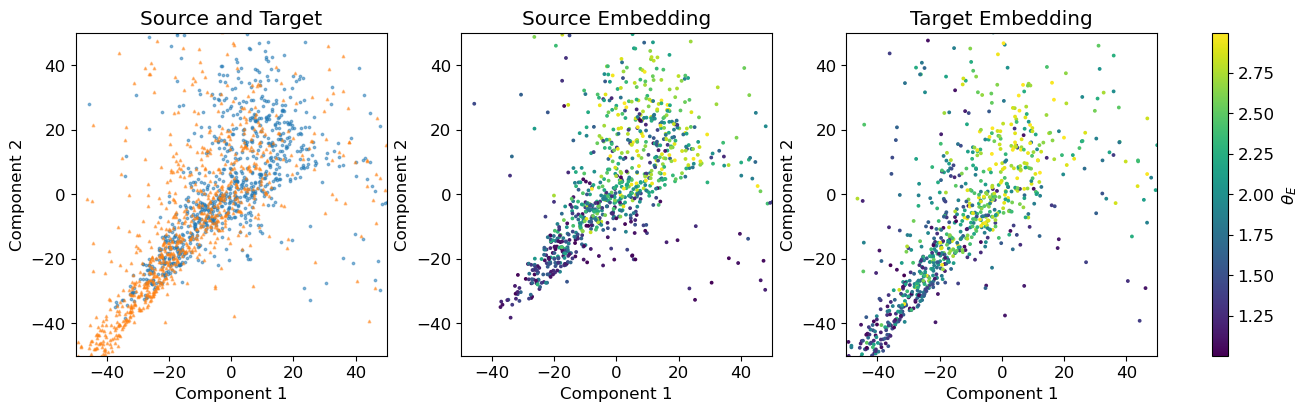


Epoch 0: 47.59s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1417
	Train Regression Loss: : 0.4880
	Train Mve Loss: : 0.1288
	Train R2 Score: : -0.4998
 Validation Statistics:
	Val Source Regression Loss: : 0.0518
	Val Target Regression Loss: : 0.0642
	Val Source R2 Score: : 0.8400
	Val Target R2 Score: : 0.8067
	Val Source Mve Loss: : -0.0671
	Val Target Mve Loss: : -0.0612
Saving Model... Done.
Saving Model MVE... Done.

Epoch 1: 49.20s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0923
	Train Regression Loss: : 0.0368
	Train Mve Loss: : -0.0634
	Train R2 Score: : 0.8873
 Validation Statistics:
	Val Source Regression Loss: : 0.0276
	Val Target Regression Loss: : 0.0334
	Val Source R2 Score: : 0.9149
	Val Target R2 Score: : 0.8995
	Val Source Mve Loss: : -0.0513
	Val Target Mve Loss: : -0.0484
Saving Model... Done.

Epoch 2: 49.10s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0798
	Train Regression 

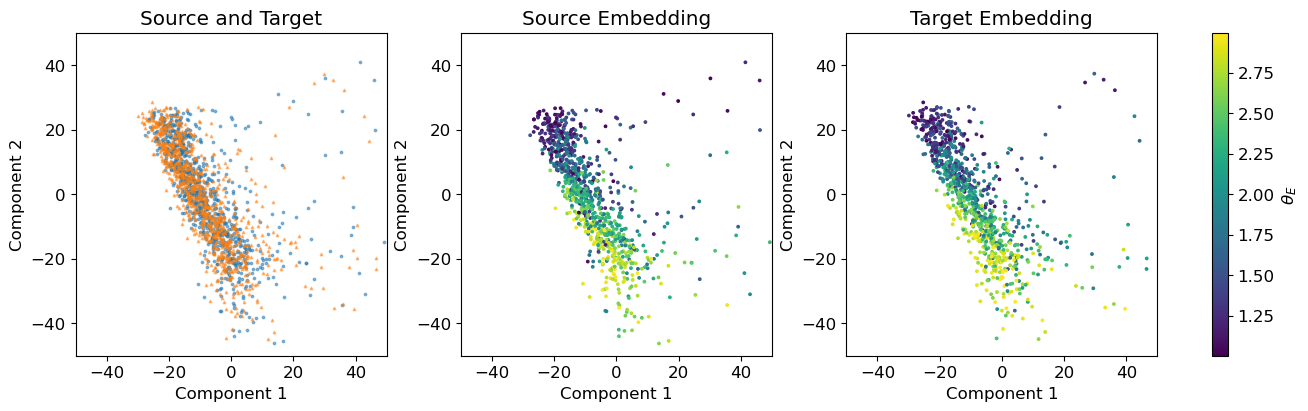

Saving Model... Done.

Epoch 20: 50.56s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0329
	Train Regression Loss: : 0.0119
	Train Mve Loss: : -0.0434
	Train R2 Score: : 0.9637
 Validation Statistics:
	Val Source Regression Loss: : 0.0117
	Val Target Regression Loss: : 0.0165
	Val Source R2 Score: : 0.9636
	Val Target R2 Score: : 0.9501
	Val Source Mve Loss: : -0.0526
	Val Target Mve Loss: : -0.0502
Saving Model... Done.

Epoch 21: 42.95s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0327
	Train Regression Loss: : 0.0116
	Train Mve Loss: : -0.0504
	Train R2 Score: : 0.9645
 Validation Statistics:
	Val Source Regression Loss: : 0.0115
	Val Target Regression Loss: : 0.0166
	Val Source R2 Score: : 0.9642
	Val Target R2 Score: : 0.9507
	Val Source Mve Loss: : -0.0782
	Val Target Mve Loss: : -0.0751
Saving Model... Done.

Epoch 22: 45.00s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0316
	Train Regression L

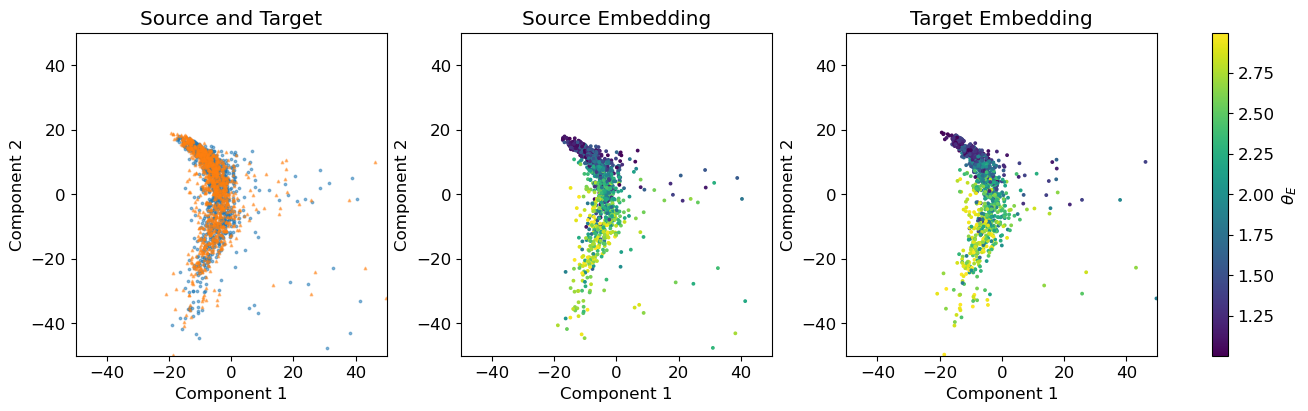


Epoch 40: 46.28s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0252
	Train Regression Loss: : 0.0094
	Train Mve Loss: : -0.1333
	Train R2 Score: : 0.9710
 Validation Statistics:
	Val Source Regression Loss: : 0.0094
	Val Target Regression Loss: : 0.0136
	Val Source R2 Score: : 0.9709
	Val Target R2 Score: : 0.9590
	Val Source Mve Loss: : -0.0889
	Val Target Mve Loss: : -0.0811

Epoch 41: 42.24s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0252
	Train Regression Loss: : 0.0093
	Train Mve Loss: : -0.1471
	Train R2 Score: : 0.9713
 Validation Statistics:
	Val Source Regression Loss: : 0.0090
	Val Target Regression Loss: : 0.0162
	Val Source R2 Score: : 0.9720
	Val Target R2 Score: : 0.9515
	Val Source Mve Loss: : -0.0977
	Val Target Mve Loss: : -0.0719

Epoch 42: 41.96s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0260
	Train Regression Loss: : 0.0091
	Train Mve Loss: : -0.0768
	Train R2 Score: : 0.9721

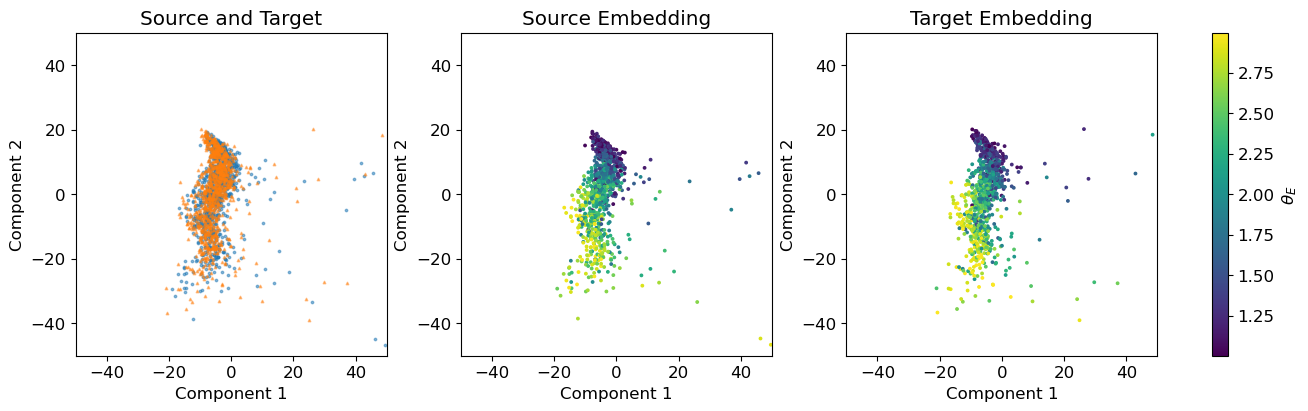

Saving Model... Done.

Epoch 60: 46.83s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0217
	Train Regression Loss: : 0.0079
	Train Mve Loss: : -0.1187
	Train R2 Score: : 0.9757
 Validation Statistics:
	Val Source Regression Loss: : 0.0077
	Val Target Regression Loss: : 0.0107
	Val Source R2 Score: : 0.9761
	Val Target R2 Score: : 0.9676
	Val Source Mve Loss: : -0.0703
	Val Target Mve Loss: : -0.0649

Epoch 61: 45.12s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0209
	Train Regression Loss: : 0.0077
	Train Mve Loss: : -0.1160
	Train R2 Score: : 0.9765
 Validation Statistics:
	Val Source Regression Loss: : 0.0081
	Val Target Regression Loss: : 0.0120
	Val Source R2 Score: : 0.9751
	Val Target R2 Score: : 0.9643
	Val Source Mve Loss: : -0.1260
	Val Target Mve Loss: : -0.0763

Epoch 62: 41.00s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0206
	Train Regression Loss: : 0.0077
	Train Mve Loss: : -0.0829
	Tr

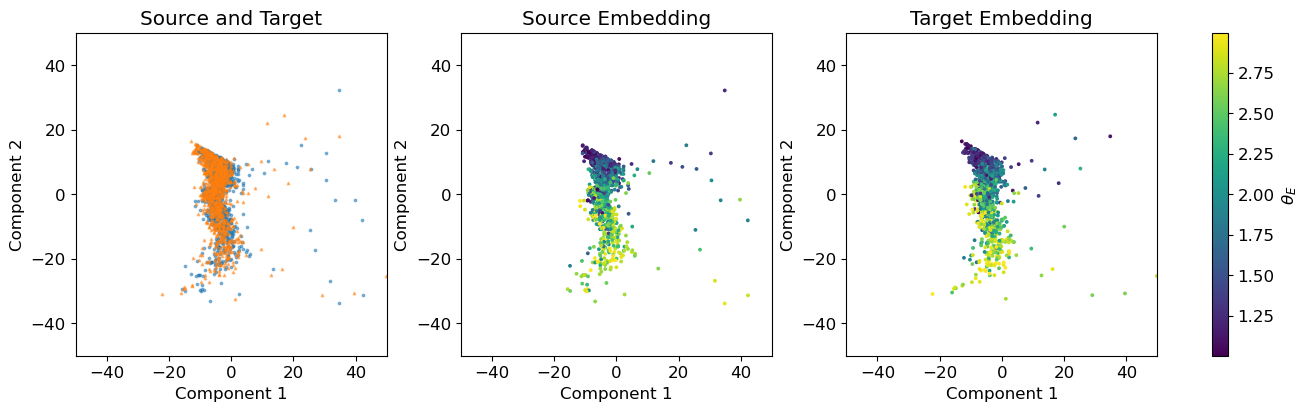


Epoch 80: 47.72s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0184
	Train Regression Loss: : 0.0073
	Train Mve Loss: : -0.1443
	Train R2 Score: : 0.9775
 Validation Statistics:
	Val Source Regression Loss: : 0.0073
	Val Target Regression Loss: : 0.0098
	Val Source R2 Score: : 0.9772
	Val Target R2 Score: : 0.9707
	Val Source Mve Loss: : -0.1042
	Val Target Mve Loss: : -0.0998
Saving Model... Done.

Epoch 81: 45.45s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0184
	Train Regression Loss: : 0.0074
	Train Mve Loss: : -0.1931
	Train R2 Score: : 0.9774
 Validation Statistics:
	Val Source Regression Loss: : 0.0073
	Val Target Regression Loss: : 0.0151
	Val Source R2 Score: : 0.9773
	Val Target R2 Score: : 0.9547
	Val Source Mve Loss: : -0.0994
	Val Target Mve Loss: : 0.2717

Epoch 82: 42.04s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0189
	Train Regression Loss: : 0.0071
	Train Mve Loss: : -0.1292
	Tra

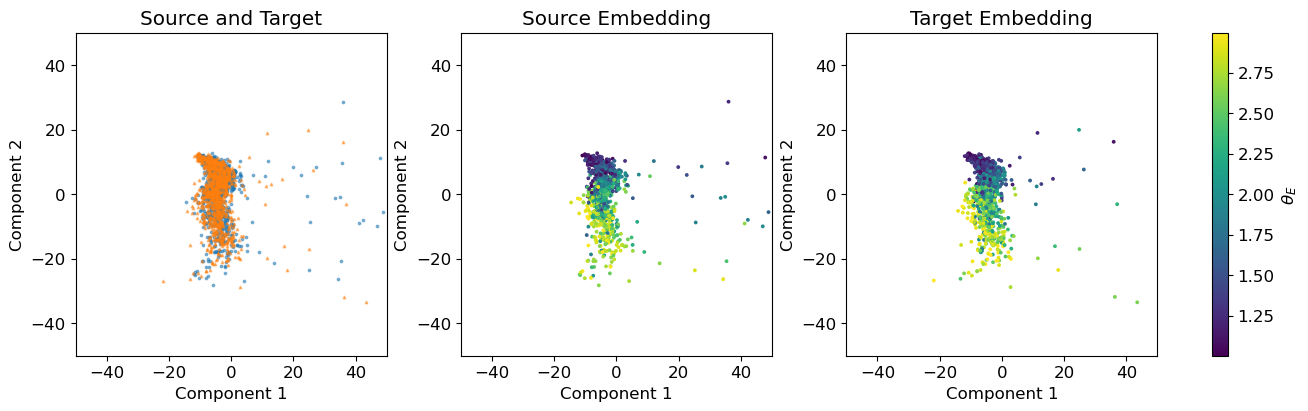

Saving Model... Done.

Epoch 100: 51.25s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0171
	Train Regression Loss: : 0.0063
	Train Mve Loss: : -0.1589
	Train R2 Score: : 0.9807
 Validation Statistics:
	Val Source Regression Loss: : 0.0065
	Val Target Regression Loss: : 0.0110
	Val Source R2 Score: : 0.9800
	Val Target R2 Score: : 0.9675
	Val Source Mve Loss: : -0.0896
	Val Target Mve Loss: : 0.5241

Epoch 101: 44.82s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0177
	Train Regression Loss: : 0.0066
	Train Mve Loss: : -0.2826
	Train R2 Score: : 0.9798
 Validation Statistics:
	Val Source Regression Loss: : 0.0063
	Val Target Regression Loss: : 0.0097
	Val Source R2 Score: : 0.9803
	Val Target R2 Score: : 0.9707
	Val Source Mve Loss: : -0.3010
	Val Target Mve Loss: : -0.2441

Epoch 102: 44.48s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0185
	Train Regression Loss: : 0.0064
	Train Mve Loss: : -0.2967
	

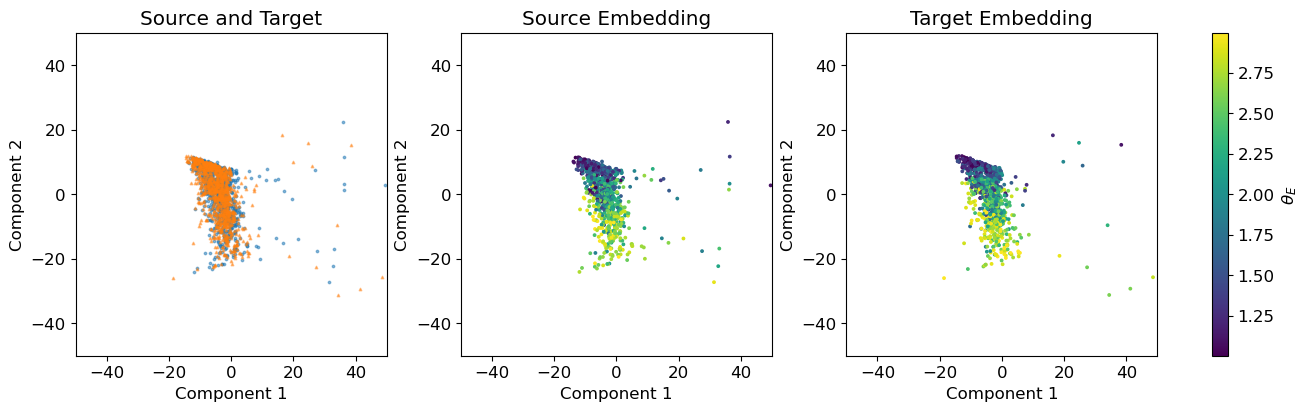

Saving Model MVE... Done.

Epoch 120: 48.56s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0174
	Train Regression Loss: : 0.0065
	Train Mve Loss: : -0.3324
	Train R2 Score: : 0.9802
 Validation Statistics:
	Val Source Regression Loss: : 0.0068
	Val Target Regression Loss: : 0.0105
	Val Source R2 Score: : 0.9790
	Val Target R2 Score: : 0.9684
	Val Source Mve Loss: : -0.2930
	Val Target Mve Loss: : -0.2793

Epoch 121: 49.31s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0177
	Train Regression Loss: : 0.0068
	Train Mve Loss: : -0.2591
	Train R2 Score: : 0.9791
 Validation Statistics:
	Val Source Regression Loss: : 0.0080
	Val Target Regression Loss: : 0.0107
	Val Source R2 Score: : 0.9752
	Val Target R2 Score: : 0.9676
	Val Source Mve Loss: : -0.2342
	Val Target Mve Loss: : -0.2219

Epoch 122: 42.46s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0182
	Train Regression Loss: : 0.0071
	Train Mve Loss: : -0.3

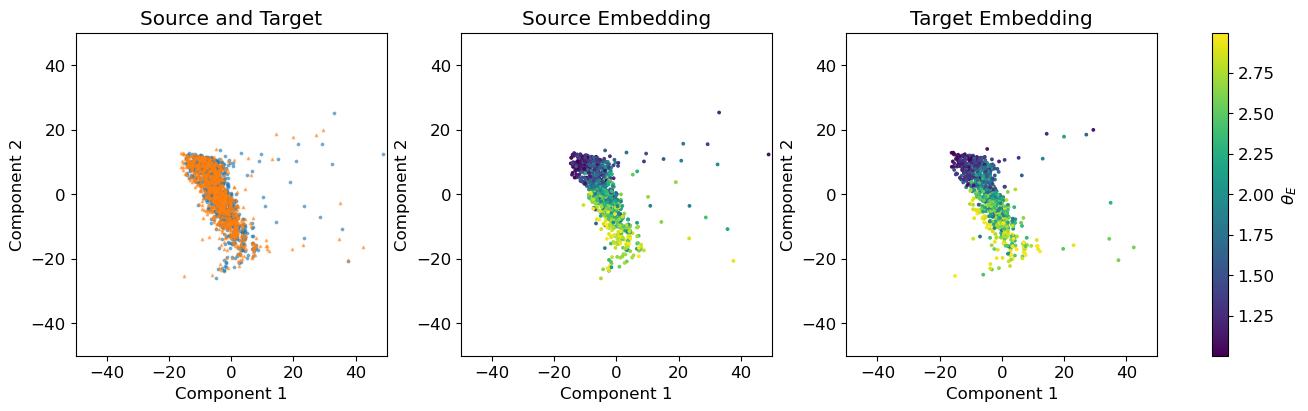


Epoch 140: 46.58s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0183
	Train Regression Loss: : 0.0077
	Train Mve Loss: : -0.0528
	Train R2 Score: : 0.9764
 Validation Statistics:
	Val Source Regression Loss: : 0.0069
	Val Target Regression Loss: : 0.0115
	Val Source R2 Score: : 0.9783
	Val Target R2 Score: : 0.9660
	Val Source Mve Loss: : -0.2246
	Val Target Mve Loss: : 1.4538

Epoch 141: 46.35s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0189
	Train Regression Loss: : 0.0072
	Train Mve Loss: : -0.1747
	Train R2 Score: : 0.9779
 Validation Statistics:
	Val Source Regression Loss: : 0.0068
	Val Target Regression Loss: : 0.0114
	Val Source R2 Score: : 0.9790
	Val Target R2 Score: : 0.9655
	Val Source Mve Loss: : 0.1530
	Val Target Mve Loss: : 1.7213

Epoch 142: 45.33s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0184
	Train Regression Loss: : 0.0065
	Train Mve Loss: : -0.3090
	Train R2 Score: : 0.9802

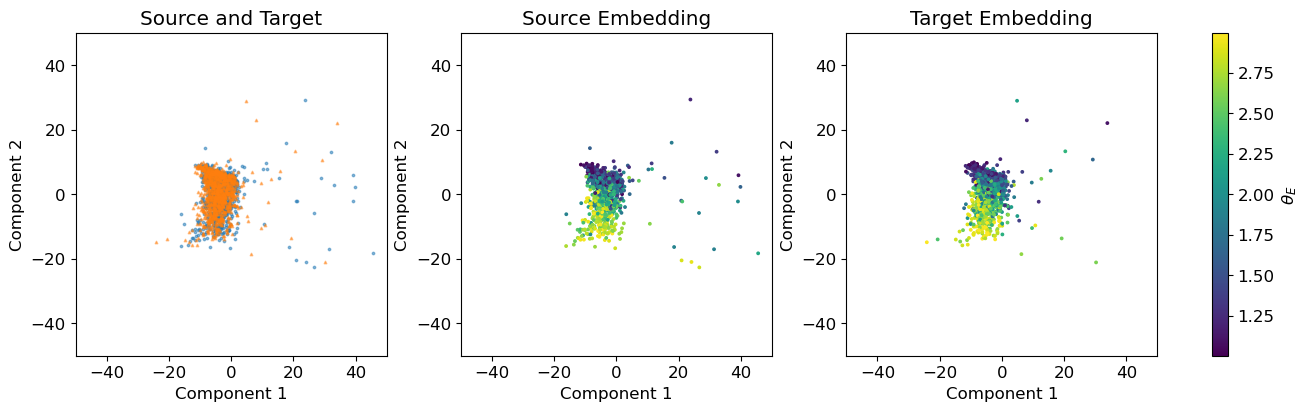


Epoch 160: 47.43s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0187
	Train Regression Loss: : 0.0066
	Train Mve Loss: : -0.3894
	Train R2 Score: : 0.9798
 Validation Statistics:
	Val Source Regression Loss: : 0.0063
	Val Target Regression Loss: : 0.0108
	Val Source R2 Score: : 0.9807
	Val Target R2 Score: : 0.9668
	Val Source Mve Loss: : 0.2775
	Val Target Mve Loss: : 2.5593

Epoch 161: 45.41s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0193
	Train Regression Loss: : 0.0079
	Train Mve Loss: : -0.1483
	Train R2 Score: : 0.9757
 Validation Statistics:
	Val Source Regression Loss: : 0.0097
	Val Target Regression Loss: : 0.0168
	Val Source R2 Score: : 0.9692
	Val Target R2 Score: : 0.9496
	Val Source Mve Loss: : -0.4884
	Val Target Mve Loss: : 0.6585

Epoch 162: 39.94s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0213
	Train Regression Loss: : 0.0110
	Train Mve Loss: : -0.4107
	Train R2 Score: : 0.9662

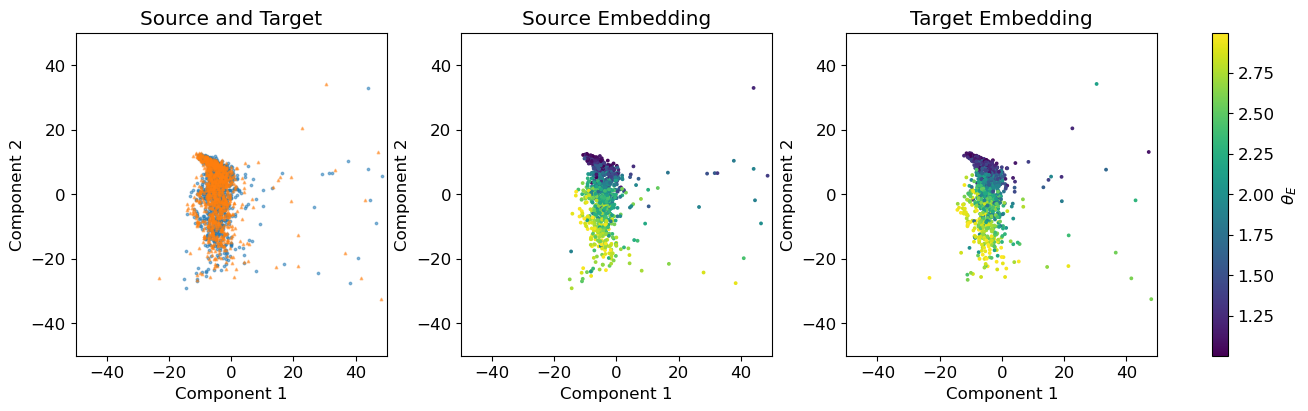


Epoch 180: 48.09s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0195
	Train Regression Loss: : 0.0069
	Train Mve Loss: : -0.5015
	Train R2 Score: : 0.9787
 Validation Statistics:
	Val Source Regression Loss: : 0.0066
	Val Target Regression Loss: : 0.0108
	Val Source R2 Score: : 0.9793
	Val Target R2 Score: : 0.9673
	Val Source Mve Loss: : -0.5060
	Val Target Mve Loss: : 2.1260

Epoch 181: 46.09s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0189
	Train Regression Loss: : 0.0064
	Train Mve Loss: : -0.5163
	Train R2 Score: : 0.9805
 Validation Statistics:
	Val Source Regression Loss: : 0.0063
	Val Target Regression Loss: : 0.0096
	Val Source R2 Score: : 0.9804
	Val Target R2 Score: : 0.9713
	Val Source Mve Loss: : -0.5239
	Val Target Mve Loss: : 5.7007

Epoch 182: 44.07s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0198
	Train Regression Loss: : 0.0061
	Train Mve Loss: : -0.5405
	Train R2 Score: : 0.981

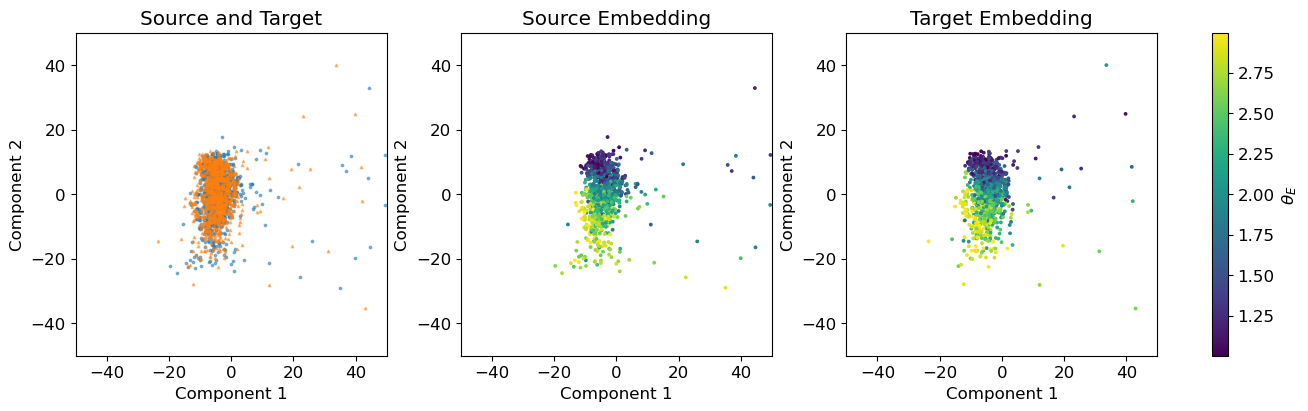


Epoch 200: 44.95s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0202
	Train Regression Loss: : 0.0071
	Train Mve Loss: : -0.2334
	Train R2 Score: : 0.9781
 Validation Statistics:
	Val Source Regression Loss: : 0.0071
	Val Target Regression Loss: : 0.0114
	Val Source R2 Score: : 0.9780
	Val Target R2 Score: : 0.9646
	Val Source Mve Loss: : 0.2235
	Val Target Mve Loss: : 181.3321

Epoch 201: 44.56s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0207
	Train Regression Loss: : 0.0169
	Train Mve Loss: : 0.8643
	Train R2 Score: : 0.9478
 Validation Statistics:
	Val Source Regression Loss: : 0.0206
	Val Target Regression Loss: : 0.0271
	Val Source R2 Score: : 0.9358
	Val Target R2 Score: : 0.9185
	Val Source Mve Loss: : -0.5430
	Val Target Mve Loss: : 4.4816

Epoch 202: 42.35s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0200
	Train Regression Loss: : 0.0197
	Train Mve Loss: : -0.5487
	Train R2 Score: : 0.939

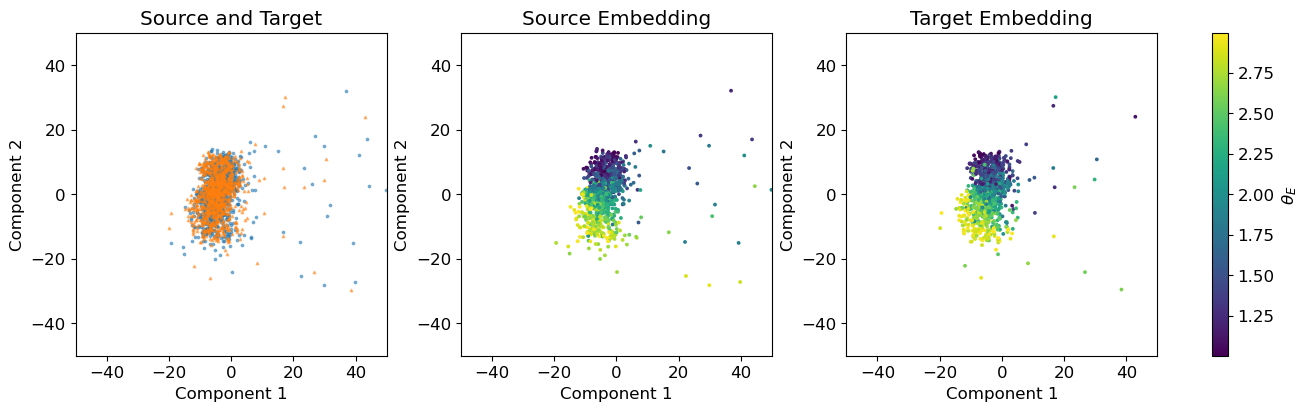


Epoch 220: 49.96s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0211
	Train Regression Loss: : 0.0172
	Train Mve Loss: : -0.4911
	Train R2 Score: : 0.9469
 Validation Statistics:
	Val Source Regression Loss: : 0.0134
	Val Target Regression Loss: : 0.0189
	Val Source R2 Score: : 0.9579
	Val Target R2 Score: : 0.9430
	Val Source Mve Loss: : -0.9388
	Val Target Mve Loss: : 142.7754

Epoch 221: 41.60s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0217
	Train Regression Loss: : 0.0091
	Train Mve Loss: : 0.5711
	Train R2 Score: : 0.9722
 Validation Statistics:
	Val Source Regression Loss: : 0.0077
	Val Target Regression Loss: : 0.0108
	Val Source R2 Score: : 0.9761
	Val Target R2 Score: : 0.9675
	Val Source Mve Loss: : -0.6852
	Val Target Mve Loss: : -0.2988

Epoch 222: 41.17s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0198
	Train Regression Loss: : 0.0080
	Train Mve Loss: : -0.5464
	Train R2 Score: : 0.9

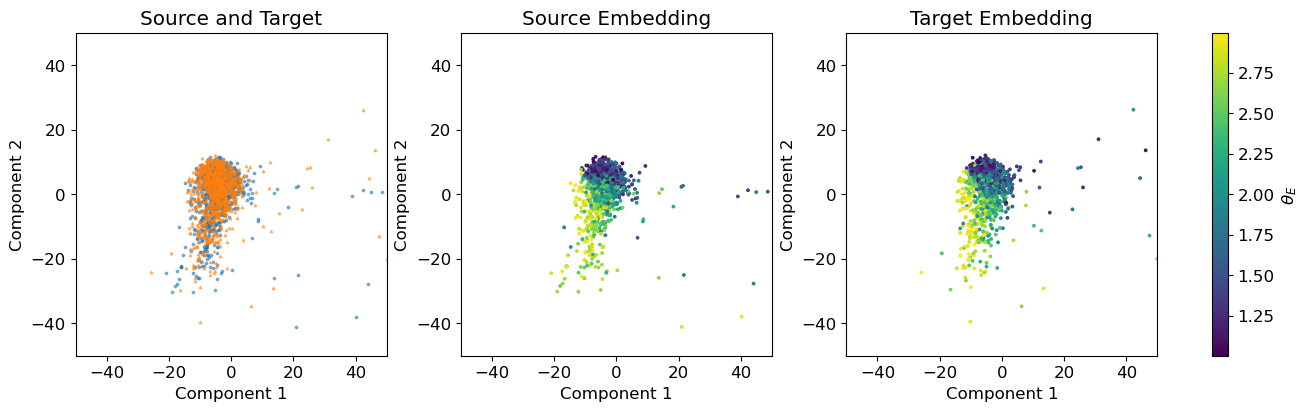


Epoch 240: 43.66s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0222
	Train Regression Loss: : 0.0580
	Train Mve Loss: : -0.2668
	Train R2 Score: : 0.8213
 Validation Statistics:
	Val Source Regression Loss: : 0.0423
	Val Target Regression Loss: : 0.0500
	Val Source R2 Score: : 0.8678
	Val Target R2 Score: : 0.8482
	Val Source Mve Loss: : 24.0469
	Val Target Mve Loss: : 793.9556

Epoch 241: 48.81s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0225
	Train Regression Loss: : 0.0357
	Train Mve Loss: : 9.9149
	Train R2 Score: : 0.8899
 Validation Statistics:
	Val Source Regression Loss: : 0.0316
	Val Target Regression Loss: : 0.0378
	Val Source R2 Score: : 0.9018
	Val Target R2 Score: : 0.8860
	Val Source Mve Loss: : -1.0562
	Val Target Mve Loss: : 1002.7583

Epoch 242: 41.87s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0225
	Train Regression Loss: : 0.0490
	Train Mve Loss: : 3.0710
	Train R2 Score: : 0.

In [10]:
print("Beginning Training...")


for curr_epoch in range(stats['epoch_no'], stats['epoch_no'] + n_epoch):

        # Generate isomaps every 20 epochs
        if (curr_epoch % 20 == 0):
            print("Generating Isomap...")
            source_iso, target_iso = generate_isomaps(source_data, target_data, model)
            show_isomaps(source_iso, 
                         target_iso, 
                         isomap_source_label_sample, 
                         isomap_target_label_sample, 
                         save_mod_name, 
                         name = stats["epoch_no"], 
                         axlim = 50, save = True)

        # Save best models
        if (len(stats['val_target_r2_score']) > 0):
            
            # Save and overwrite model every best target R2
            if (stats['val_target_r2_score'][-1] > best_target_R2):
                print("Saving Model...", end = ' ')
                save_model(save_mod_name, model, optimizer, stats)
                best_target_R2 = stats['val_target_r2_score'][-1]
                print("Done.")
                
            # Save and overwrite model every best target MVE Loss
            if (stats['val_target_mve_loss'][-1] < best_mve_loss):
                print("Saving Model MVE...", end = ' ')
                mve_name = save_mod_name + "_mve"
                save_model(mve_name, model, optimizer, stats)
                best_mve_loss = stats['val_target_mve_loss'][-1]
                print("Done.")

        
        start_time = time.time()

        beta = beta_function(curr_epoch)
        da_weight = da_weight_function(curr_epoch)

        # Train, backpropagate
        vals = train_loop_mve(source_train_dataloader, 
                              target_train_dataloader, 
                              model,
                              regressor_loss_fn, 
                              da_loss_fn, 
                              optimizer,
                              da_weight, 
                              beta)

        # Test, validate metrics
        vals_validate = test_loop_mve(source_val_dataloader, 
                                      target_val_dataloader,
                                      model, 
                                      regressor_loss_fn, 
                                      beta)

        # Training Metrics
        stats['train_DA_loss'].append(vals[0])
        stats['train_regression_loss'].append(vals[1])
        stats['train_mve_loss'].append(vals[2])
        stats['train_r2_score'].append(vals[3])

        # Validation Metrics
        stats['val_source_regression_loss'].append(vals_validate[0])
        stats['val_target_regression_loss'].append(vals_validate[1])
        stats['val_source_r2_score'].append(vals_validate[2])
        stats['val_target_r2_score'].append(vals_validate[3])
        stats['val_source_mve_loss'].append(vals_validate[4])
        stats['val_target_mve_loss'].append(vals_validate[5])
        
        # Other Parameters
        stats['da_weight'].append(da_weight)
        stats['beta'].append(beta)
        stats['epoch_no'] += 1

        print_epoch_scores(stats, curr_epoch, time.time() - start_time)

In [11]:
# Saves the end result model after running for all stages, as well as the .json of stats

state = {
    'epoch': stats['epoch_no'],
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict(),
}
final_mod_name = save_mod_name + "_final"
torch.save(state, final_mod_name)
json.dump(stats, open(final_mod_name+'.json', 'w'))

## Visualize Results

In [10]:
# Loads a model for plotting/viz

viz_mod_name = final_mod_name # "models/start_code_test_4_final"
model.load_state_dict(torch.load(viz_mod_name)['state_dict'])
stats = json.load(open(viz_mod_name+'.json', 'r'))

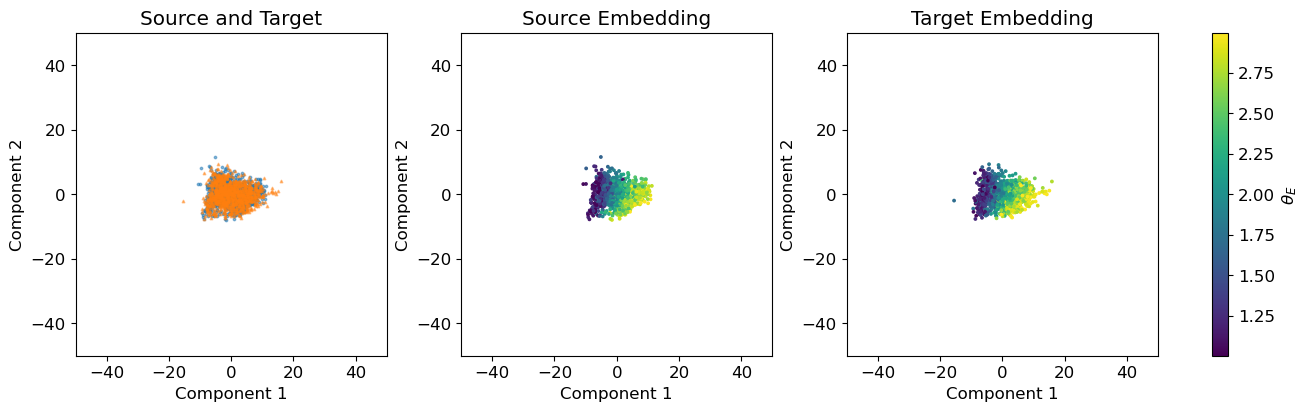

(<Figure size 1300x400 with 4 Axes>,
 array([<Axes: title={'center': 'Source and Target'}, xlabel='Component 1', ylabel='Component 2'>,
        <Axes: title={'center': 'Source Embedding'}, xlabel='Component 1', ylabel='Component 2'>,
        <Axes: title={'center': 'Target Embedding'}, xlabel='Component 1', ylabel='Component 2'>],
       dtype=object))

In [11]:
# Visualize isomaps 
trained_source_iso, trained_target_iso = generate_isomaps(source_data, target_data, model)
show_isomaps(trained_source_iso, trained_target_iso, isomap_source_label_sample, isomap_target_label_sample, viz_mod_name, axlim = 50)

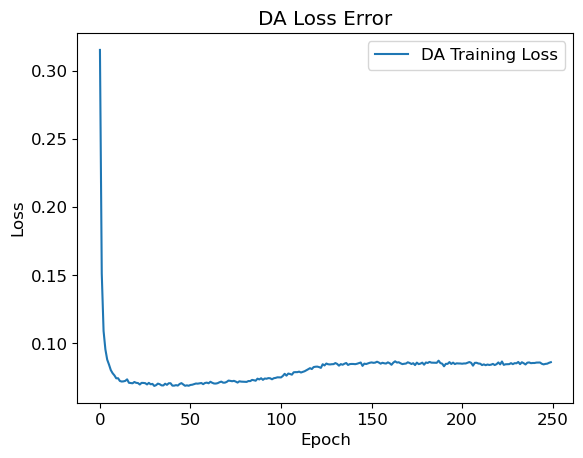

In [12]:
# DA Loss
fmt = lambda k: " ".join([i.capitalize() for i in k.split('_')])
eps = np.arange(stats["epoch_no"])
plt.title("DA Loss Error")
plt.plot(eps, stats['train_DA_loss'], label = "DA Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

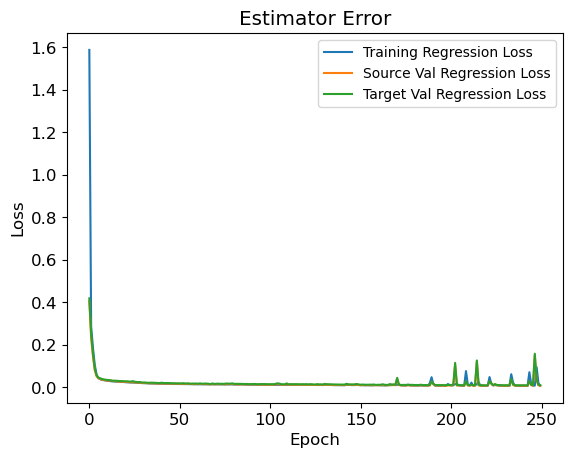

In [13]:
# Estimator / Regression
plt.title("Estimator Error")
plt.plot(eps, stats['train_regression_loss'], label = "Training Regression Loss")
plt.plot(eps, stats['val_source_regression_loss'], label = "Source Val Regression Loss")
plt.plot(eps, stats['val_target_regression_loss'], label = "Target Val Regression Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(fontsize = 'small')

(-1.0, 1.0)

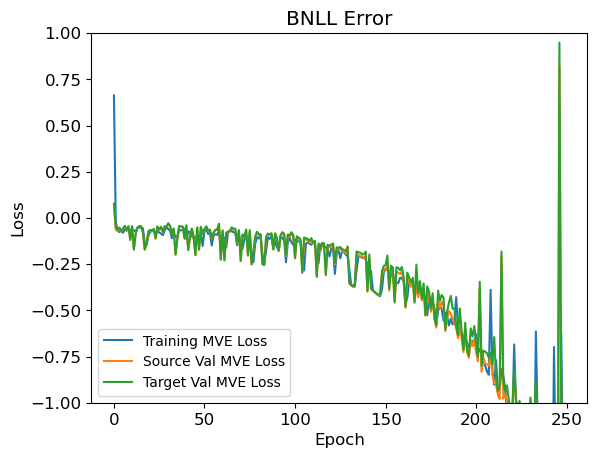

In [14]:
# BNLL for MVE
plt.title("BNLL Error")
plt.plot(eps, stats['train_mve_loss'], label = "Training MVE Loss")
plt.plot(eps, stats['val_source_mve_loss'], label = "Source Val MVE Loss")
plt.plot(eps, stats['val_target_mve_loss'], label = "Target Val MVE Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(fontsize = 'small')
plt.ylim(-1, 1)

(0.5, 1.0)

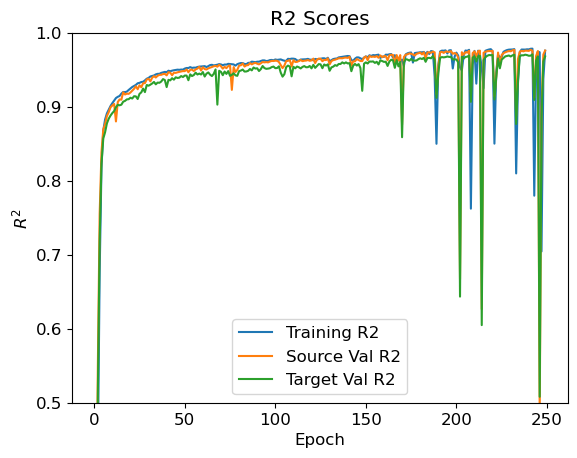

In [15]:
# R2 Scores
plt.title("R2 Scores")
plt.plot(eps, stats['train_r2_score'], label = "Training R2")
plt.plot(eps, stats['val_source_r2_score'], label = "Source Val R2")
plt.plot(eps, stats['val_target_r2_score'], label = "Target Val R2")
plt.xlabel("Epoch")
plt.ylabel("$R^2$")
plt.legend()
plt.ylim(0.5, 1)

In [26]:
# Test Source
var_preds_source = np.array([])
preds_source = np.array([])
true_source = np.array([])
lbnll_source = np.array([])
score_list = np.array([])

with torch.no_grad():
    for X, y in source_test_dataloader:
        X = X.float()
        pred, _ = model(X.cuda())
        preds_source = np.append(preds_source, pred[:, 0].cpu())
        var_preds_source = np.append(var_preds_source, pred[:, 1].cpu())
        true_source = np.append(true_source, y.cpu())
        score = r2_score(y.cpu(), pred[:, 0].cpu())
        score_list = np.append(score_list, score)
        lbnll_source = np.append(lbnll_source, loss_bnll(pred[:, 0].cpu(), pred[:, 1].cpu(), y, beta = 0.5))

score = np.mean(score_list)
print(f'Source R2 Score is {score:.4f}')

Source R2 Score is 0.9767


Text(0.5, 1.0, 'MMD | Source | R2: 0.977')

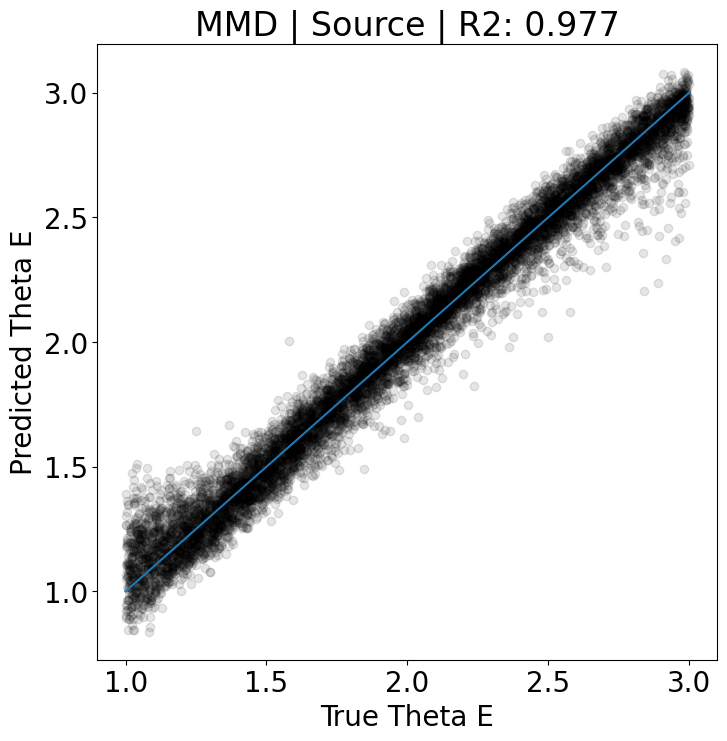

In [27]:
plt.figure(figsize=(8,8))
plt.scatter(true_source, preds_source,  color='black', alpha = 0.1)
line = np.linspace(1, 3, 100)
plt.plot(line, line)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Source | R2: {0:.3f}'.format(np.mean(score_list)))

Text(0.5, 1.0, 'Uncertainty | Source | BNLL: -0.175')

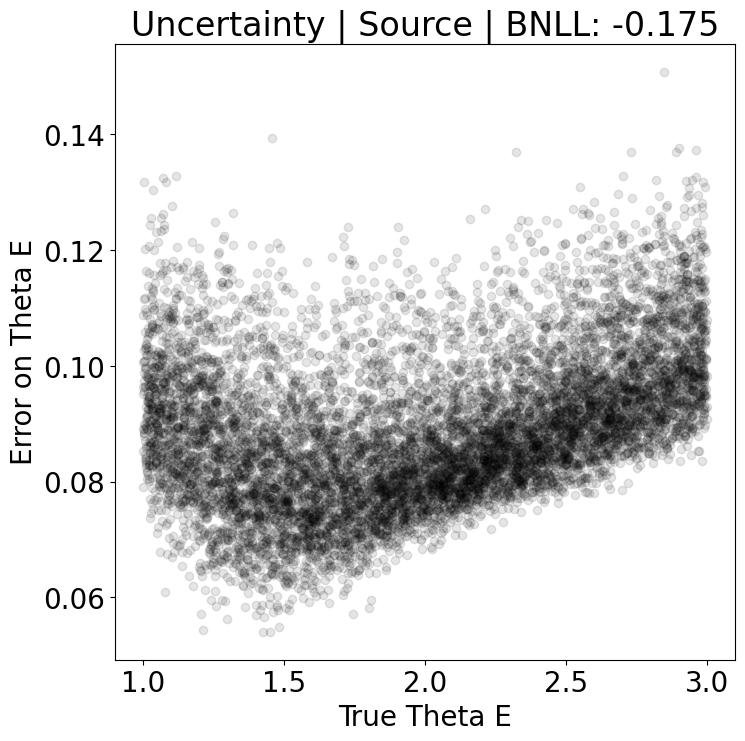

In [28]:
plt.figure(figsize=(8,8))
plt.scatter(true_source, np.sqrt(var_preds_source),  color='black', alpha = 0.1)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Error on Theta E');
plt.rc('font', size=20)
plt.title('Uncertainty | Source | BNLL: {0:.3f}'.format(np.mean(lbnll_source)))

In [29]:
# Test target
preds_target = np.array([])
var_preds_target = np.array([])
true_target = np.array([])
score_list = np.array([])
lbnll_target = np.array([])


with torch.no_grad():
    for X, y in target_test_dataloader:
        X = X.float()
        pred, _ = model(X.cuda())
        preds_target = np.append(preds_target, pred[:, 0].cpu())
        var_preds_target = np.append(var_preds_target, pred[:, 1].cpu())
        true_target = np.append(true_target, y.cpu())
        score = r2_score(y.cpu(), pred[:, 0].cpu())
        score_list = np.append(score_list, score)
        lbnll_target = np.append(lbnll_target, loss_bnll(pred[:, 0].cpu(), pred[:, 1].cpu(), y, beta = 0.5))


score = np.mean(score_list)
print(f'Target R2 Score is {score:.4f}')

Target R2 Score is 0.9661


Text(0.5, 1.0, 'MMD | Target | R2: 0.966')

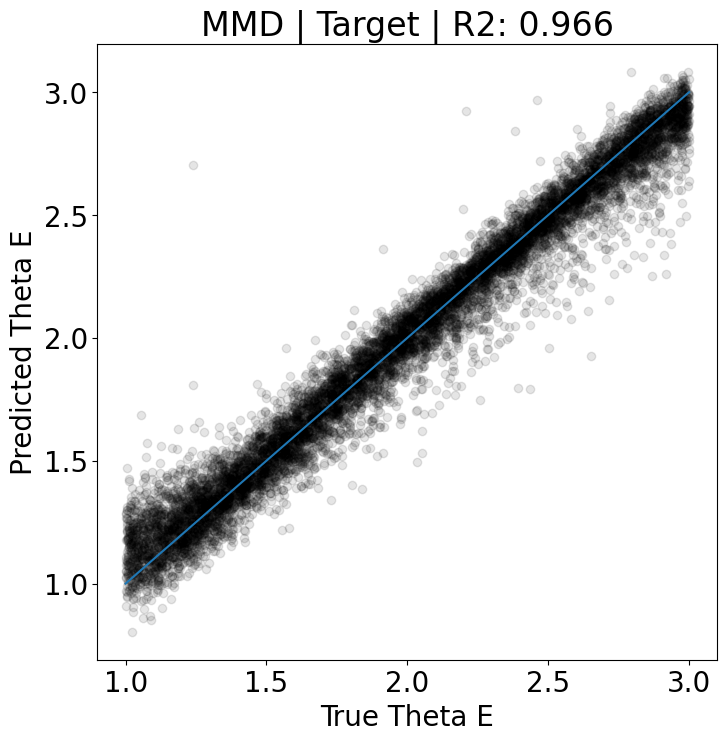

In [30]:
plt.figure(figsize=(8,8))
plt.scatter(true_target, preds_target,  color='black', alpha = 0.1)
line = np.linspace(1, 3, 100)
plt.plot(line, line)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Target | R2: {0:.3f}'.format(np.mean(score_list)))

Text(0.5, 1.0, 'MMD | Target | R2: 0.966')

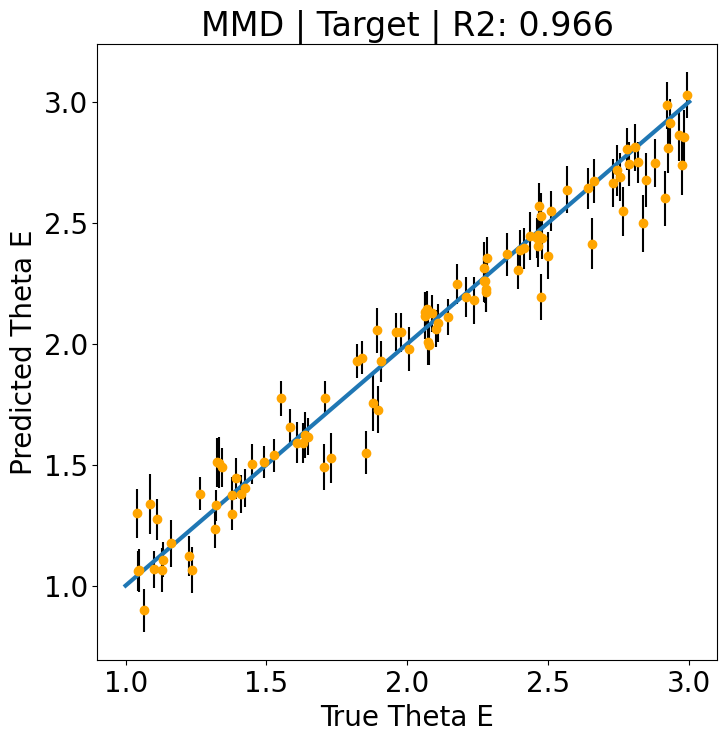

In [31]:
plt.figure(figsize=(8,8))
idx = np.random.choice(np.arange(len(true_target)), 100)
plt.errorbar(true_target[idx], preds_target[idx], yerr = np.sqrt(var_preds_target[idx]), fmt = 'o', color='orange', ecolor = 'k', alpha = 1)
line = np.linspace(1, 3, 100)
plt.plot(line, line, lw = 3)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Target | R2: {0:.3f}'.format(np.mean(score_list)))

Text(0.5, 1.0, 'Uncertainty | Target | BNLL: -0.156')

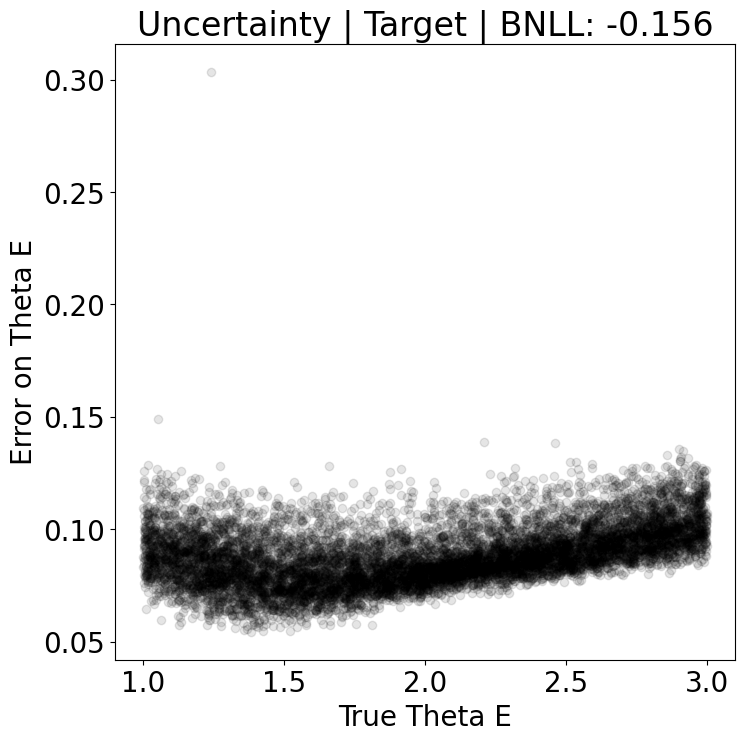

In [32]:
plt.figure(figsize=(8,8))
plt.scatter(true_target, np.sqrt(var_preds_target),  color='black', alpha = 0.1)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Error on Theta E');
plt.rc('font', size=20)
plt.title('Uncertainty | Target | BNLL: {0:.3f}'.format(np.mean(lbnll_target)))

In [33]:
def sample_variance(obs, true):
    return np.std(obs - true) ** 2

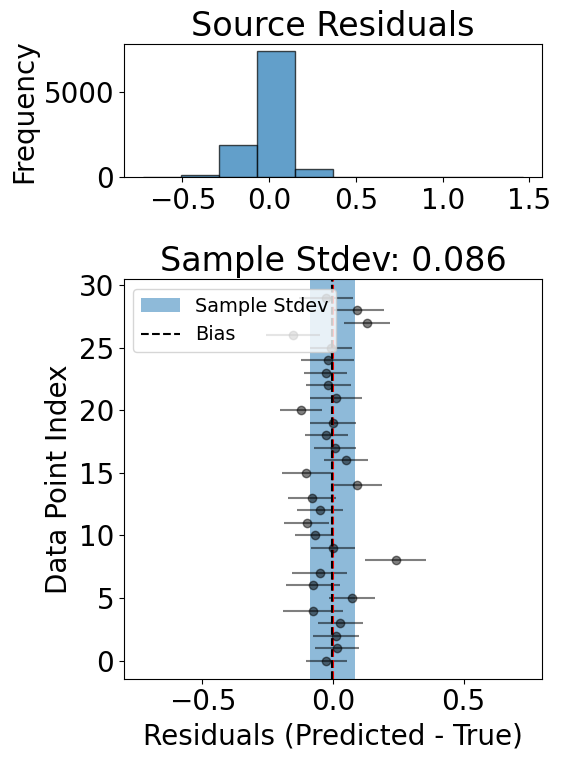

In [34]:
n_points = 30
rand_idx = np.random.choice(np.arange(len(preds_source)), n_points)
residuals = preds_source[rand_idx] - true_source[rand_idx]
resid_all = preds_target - true_target
errors = np.sqrt(var_preds_source[rand_idx])
sv = np.sqrt(sample_variance(preds_source, true_source))
mn = np.mean(resid_all)

# Create the figure and axes
fig, (ax_hist, ax_resid) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 3]}, figsize=(6, 8))



# Plot the histogram
ax_hist.hist(resid_all, bins=10, edgecolor='black', alpha=0.7)
ax_hist.set_title('Source Residuals')
ax_hist.set_ylabel('Frequency')

# Plot the residuals with error bars in the x-direction
ax_resid.errorbar(x=residuals, y=np.arange(n_points), xerr=errors, fmt='o', alpha=0.5, ecolor = 'k', color = 'k')
ax_resid.axvline(x=0, color='red', linestyle='--')
ax_resid.set_xlabel('Residuals (Predicted - True)')
ax_resid.set_ylabel('Data Point Index')
ax_resid.set_title('Sample Stdev: {0:.3f}'.format(sv))
ax_resid.axvspan(mn-sv, mn+sv, alpha = 0.5, label = "Sample Stdev")
ax_resid.axvline(mn, color = 'k', ls = '--', label = "Bias")
ax_resid.legend(loc = 'upper left', fontsize = 'x-small')

plt.xlim(-0.8, 0.8)

plt.tight_layout()
plt.show()

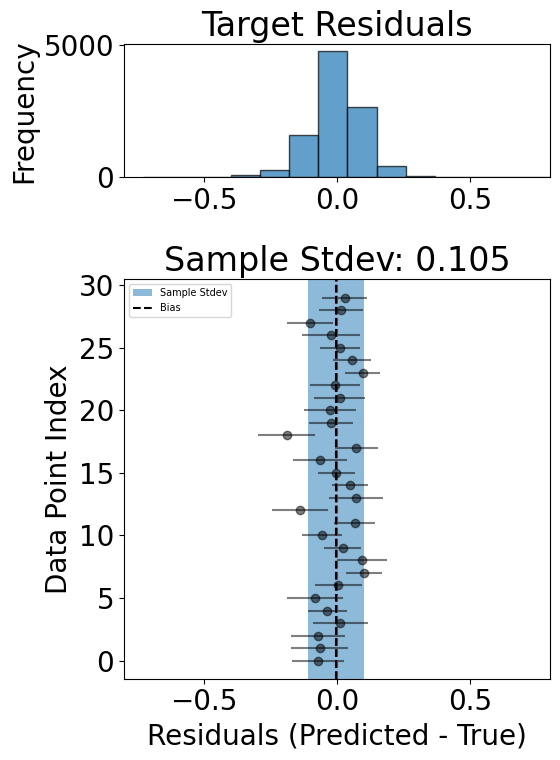

In [38]:
n_points = 30
rand_idx = np.random.choice(np.arange(len(preds_source)), n_points)
residuals = preds_target[rand_idx] - true_target[rand_idx]
resid_all = preds_target - true_target
errors = np.sqrt(var_preds_target[rand_idx])
sv = np.sqrt(sample_variance(preds_target, true_target))
mn = np.mean(resid_all)
# Create the figure and axes
fig, (ax_hist, ax_resid) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 3]}, figsize=(6, 8))



# Plot the histogram
ax_hist.hist(resid_all, bins=20, edgecolor='black', alpha=0.7)
ax_hist.set_title('Target Residuals')
ax_hist.set_ylabel('Frequency')

# Plot the residuals with error bars in the x-direction
ax_resid.errorbar(x=residuals, y=np.arange(n_points), xerr=errors, fmt='o', alpha=0.5, ecolor = 'k', color = 'k')
ax_resid.axvline(x=0, color='red', linestyle='--')
ax_resid.set_xlabel('Residuals (Predicted - True)')
ax_resid.set_ylabel('Data Point Index')
ax_resid.set_title('Sample Stdev: {0:.3f}'.format(sv))
ax_resid.axvspan(mn-sv, mn+sv, alpha = 0.5, label = "Sample Stdev")
ax_resid.axvline(mn, color = 'k', ls = '--', label = "Bias")
ax_resid.legend(loc = 'upper left', fontsize = 7)
ax_resid.sharex(ax_hist)

plt.xlim(-0.8, 0.8)

plt.tight_layout()
plt.show()